# Encoder for classifiying Images

# Logic is kinda similar to paper "Image worth of 16x16 tokens"

In [1]:
! pip install -q kagglehub 

In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.datasets import CIFAR10 
from Encoder import Encoder
from PositionalEmbeddings import RoPE
import matplotlib.pyplot as plt 
from IPython.display import clear_output
import pandas as pd
import os

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=50
IMAGE_SIZE=32
PATCH_SIZE=8
BATCH_SIZE=32
CHANNELS=3 
IMAGE_EMBEDDING_SIZE=((IMAGE_SIZE//PATCH_SIZE)**2)*CHANNELS

In [3]:
IMAGE_EMBEDDING_SIZE

48

In [4]:
os.makedirs('datasets',exist_ok=True)
tf = transforms.Compose([
    transforms.ToTensor()
])
dataset = CIFAR10('datasets',download=True,transform=tf)

In [5]:
loader = DataLoader(dataset,batch_size=BATCH_SIZE)

In [6]:
class ImageClassifierModel(nn.Module):
    def __init__(self,emb_dim,num_classes):
        super().__init__()
        self.patch_size = PATCH_SIZE 
        self.num_patches = (32 // self.patch_size) ** 2 
        rope = RoPE(emb_dim=emb_dim,seq_len=4*4,num_heads=4,device=DEVICE)
        precomputed_angles = rope.precompute_angles()

        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
        )
        self.patcher = nn.Unfold(kernel_size=(self.patch_size, self.patch_size), stride=self.patch_size)
        self.dim_reducer = nn.Sequential(
            nn.Linear(128 * self.patch_size * self.patch_size, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
        )
        self.encoders = nn.Sequential(
            Encoder(emb_dim=emb_dim,hidden_dim=emb_dim,n_heads=4,RoPE=True,RoPE_Precomputed_Angles=precomputed_angles),
            Encoder(emb_dim=emb_dim,hidden_dim=emb_dim,n_heads=4,RoPE=True,RoPE_Precomputed_Angles=precomputed_angles),
        )
        self.classifier = nn.Sequential(
            nn.Linear(emb_dim,emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim,num_classes)
        )
    def forward(self,image_tensor):
        x = self.cnn_backbone(image_tensor)
        x = self.patcher(x)
        # print(x.shape)
        x = x.transpose(1,2)
        # print(x.shape)
        x = self.dim_reducer(x)
        x = self.encoders(x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x
 


In [7]:
model = ImageClassifierModel(emb_dim=128,num_classes=10)
criterion = nn.CrossEntropyLoss()


In [8]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,factor=0.1,patience=2,min_lr=1e-6,verbose=True
)


/home/lamao/workdir/Transformers/env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
if os.path.exists("checkpoints/2_Cifar10ImageClassifier.pt"):
    model.load_state_dict(torch.load("checkpoints/2_Cifar10ImageClassifier.pt",map_location=DEVICE))
else:
    losses=[]
    loader_len = len(loader)
    plt.ion()
    for epoch in range(EPOCHS):
        running_loss=0.0
        for batch_num,batch in enumerate(loader):
            optimizer.zero_grad()
            images,classes = batch 
            images = images.to(DEVICE)
            classes = classes.to(DEVICE)
            out = model(images)
            loss = criterion(out,classes)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            running_loss+=loss.item()

            if batch_num % 100 == 0 or batch_num == len(loader) - 1:
                clear_output(wait=True)
                plt.figure(figsize=(10, 4))
                plt.plot(losses, label='Batch Loss', alpha=0.7)

                if len(losses) > 10:
                    ewma = pd.Series(losses).ewm(span=200).mean()
                    plt.plot(ewma, label='Smoothed Loss (EWMA)', color='red')

                plt.xlabel('Batch')
                plt.ylabel('Loss')
                plt.title(f'Epoch {epoch+1}/{EPOCHS}')
                plt.legend()
                plt.grid(True)
                plt.show()

            print(f"\rEpoch {epoch+1}/{EPOCHS} Batch {batch_num}/{loader_len} loss {loss.item():.6f} ", end='  ', flush=True)
            avrage_train_loss = running_loss / len(loader)
        scheduler.step(avrage_train_loss)
        

torch.Size([32, 10]) torch.Size([32])


NameError: name 'avrage_train_loss' is not defined

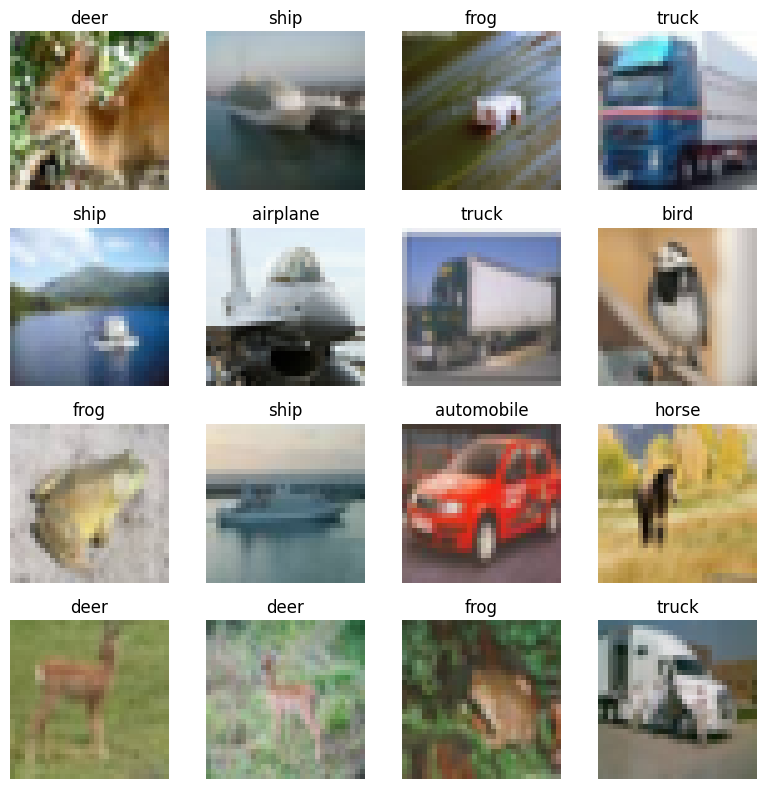

In [ ]:
import random 
images=[]
for i in range(16):
    v = random.randint(0,50_000)
    images.append(tf(dataset.data[v]).unsqueeze(0))
images_tensor = torch.cat(images,dim=0)
with torch.no_grad():
    out = model(images_tensor)
    out = torch.softmax(out,dim=-1)
    pred = torch.argmax(out,dim=-1)
pred = pred.detach().cpu()
fig,axs = plt.subplots(4,4,figsize=(8,8))
img_idx=0
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(images_tensor[img_idx].permute(1,2,0))
        axs[i,j].set_title(dataset.classes[pred[img_idx]])
        axs[i,j].set_axis_off()
        img_idx+=1
plt.tight_layout()
plt.show()